Starting feature engineering...
Feature engineering complete. Using 90 features.
Training propensity models (calibrated)...
AUC-ROC: 0.946 | PR-AUC: 0.756 | Base rate: 0.156
Identifying subscriber lookalikes...
Identified 500000 high-quality prospects | Avg prop: 0.100

SUBSCRIBER LOOKALIKE ANALYSIS SUMMARY
Total rows analyzed: 8,070,263
Current subscribers: 1,260,263 (15.6%)
High-quality prospects identified: 500,000
Average prospect propensity: 0.100
Top prospect propensity: 0.522

Eval: {'roc_auc': 0.9459293972421238, 'pr_auc': 0.7556210234308018, 'base_rate': 0.15616153868553262, 'n_train': 6456210, 'n_test': 1614053}

Lift (deciles):
   pos_rate   count      lift
0  0.770232  161406  4.932275
1  0.467061  161405  2.990884
2  0.269682  161405  1.726942
3  0.026780  161390  0.171488
4  0.012012  161419  0.076922
5  0.008061  161400  0.051618
6  0.003786  161124  0.024244
7  0.002145  160845  0.013735
8  0.001350  157049  0.008644
9  0.000540  166610  0.003459

Top 10 Feature Importa

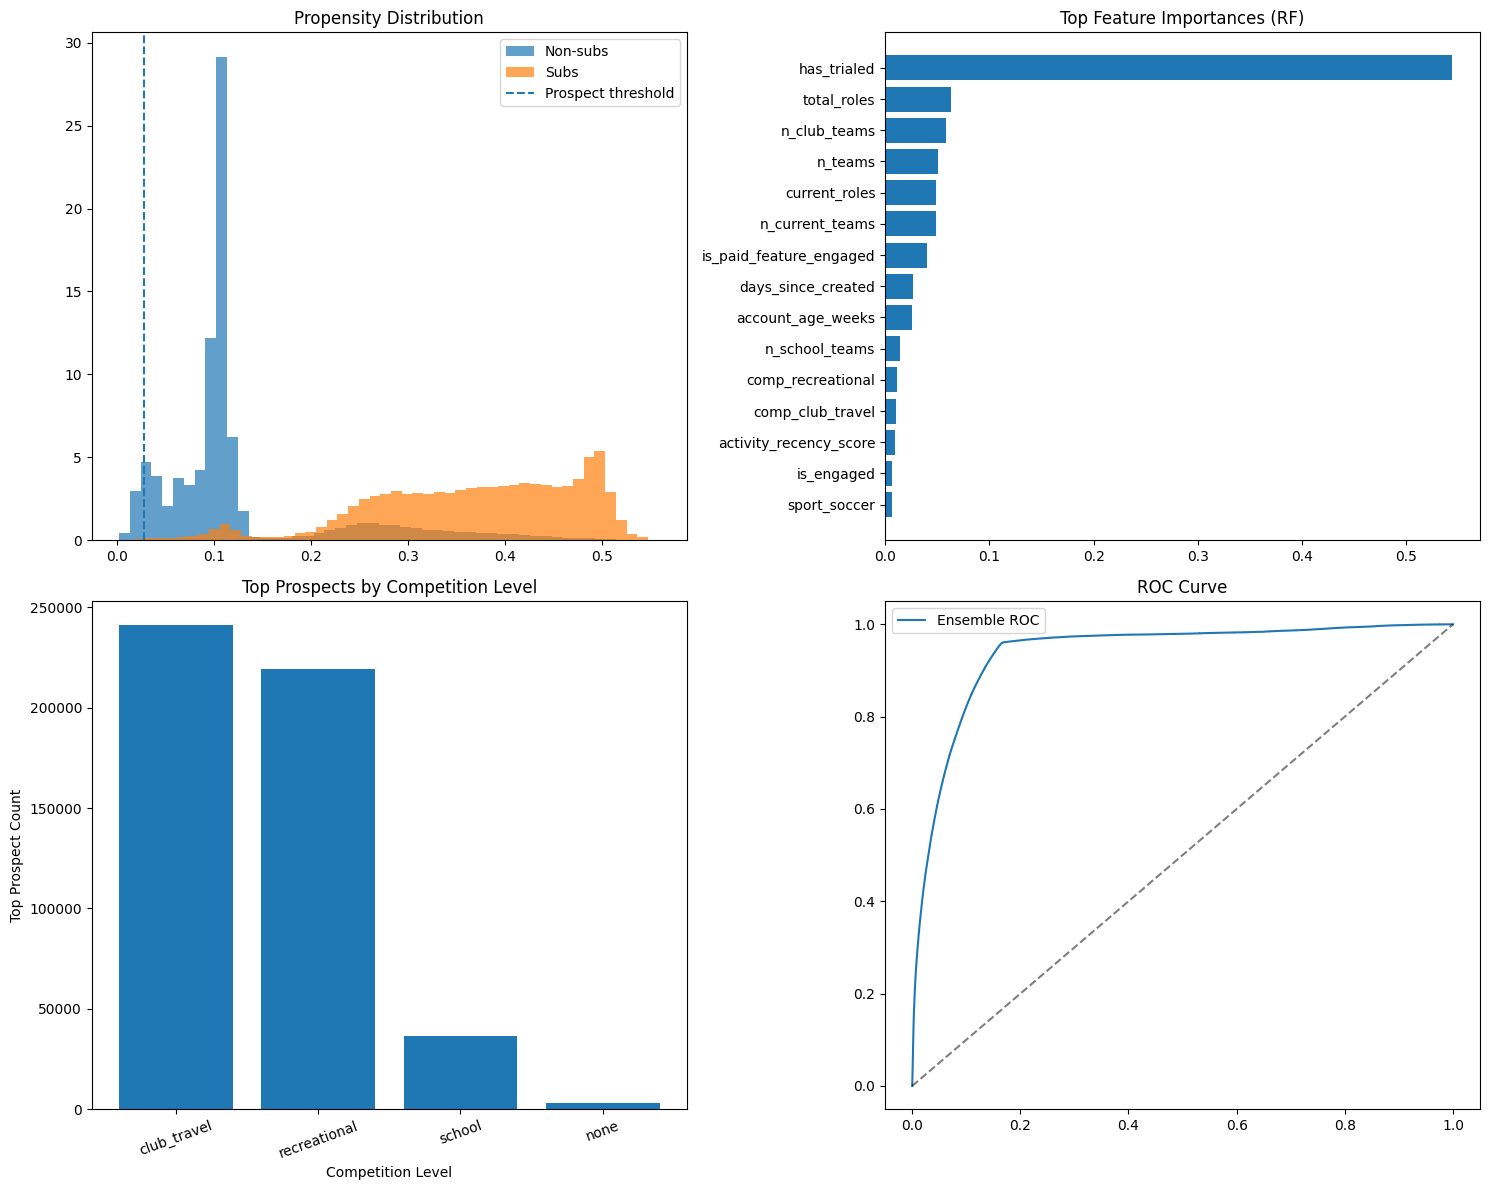

In [ ]:
# 
# Subscriber Lookalike Contest
#

#  imports & config
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score , average_precision_score , roc_curve

random.seed(42)
np.random.seed(42)

#  load 30-day window export
# one row per user per day; we will collapse to the latest row per user for most recent cut
query_2 = pd.read_csv('df2.csv')

# normalize columns to lowercase (safe with your SQL aliases)
query_2.columns = [str(c).lower() for c in query_2.columns]

# quick required-columns sanity check (kept lean on purpose)
required = {
    'user_id' , 'as_of_date' , 'is_subscriber_now' , 'is_active'
  , 'n_teams' , 'n_teams_interacted' , 'days_since_created' , 'days_since_last_active'
  , 'n_livestreams_viewed' , 'n_archived_videos_viewed' , 'n_film_review_videos_viewed'
  , 'n_play_by_plays_viewed' , 'n_player_stats_viewed' , 'n_box_scores_viewed'
  , 'n_spray_charts_viewed' , 'n_animated_gamestreams_viewed'
  , 'n_games_streamed_60_days' , 'n_games_scored_60_days' , 'n_games_covered_60_days'
  , 'n_messages_sent' , 'n_events_created' , 'n_events_rsvpd' , 'n_users_invited'
  , 'n_current_teams' , 'n_rec_teams' , 'n_club_teams' , 'n_school_teams'
  , 'n_staff_roles' , 'n_family_roles' , 'n_fan_roles' , 'n_player_roles'
  , 'n_current_staff_roles' , 'n_current_family_roles' , 'n_current_fan_roles' , 'n_current_player_roles'
  , 'is_engaged' , 'is_super_engaged'
  , 'is_team_management_engaged' , 'is_team_management_super_engaged'
  , 'is_free_feature_engaged' , 'is_free_feature_super_engaged'
  , 'is_paid_feature_engaged' , 'is_paid_feature_super_engaged'
  , 'is_coverage_producer_engaged' , 'is_coverage_producer_super_engaged'
  , 'is_successful_coverage_producer' , 'is_successful_scoring_coverage_producer' , 'is_successful_streaming_coverage_producer'
  , 'has_trialed'
  , 'primary_sport_daily' , 'primary_competition_daily' , 'self_age_group_condensed' , 'primary_state'
}
missing = sorted(required - set(query_2.columns))
if missing:
    raise ValueError(f"Input is missing required columns: {missing}")

# Core class (RF + LR ensemble)
class SubscriberLookalikeAnalysis:
    def __init__(self, df):
        self.df = df.copy()
        self.features = None
        self.target = None
        self.scaler = StandardScaler()
        self.rf_model = None
        self.lr_model = None
        self.rf_aux_for_importance = None
        self.feature_importance = None
        self.eval_metrics = {}
        self.lift_df = None
        self.test_index_mask = None
        self.ensemble_probs_all = None

    #  feature engineering
    def prepare_features(self):
        print("Starting feature engineering...")

        self.df['is_subscriber_target'] = self.df['is_subscriber_now'].astype(int)

        # ratios & recency
        self.df['engagement_per_team'] = self.df['n_teams_interacted'] / (self.df['n_teams'] + 1)
        self.df['content_per_team'] = (
              self.df['n_livestreams_viewed']
            + self.df['n_archived_videos_viewed']
        ) / (self.df['n_teams'] + 1)
        dsl = self.df['days_since_last_active'].fillna(999)
        self.df['activity_recency_score'] = np.select(
              condlist   = [dsl.eq(0), dsl.le(7), dsl.le(30)]
            , choicelist = [10      , 5        , 2]
            , default    = 1
        )

        # intensity
        self.df['total_content_viewed'] = (
              self.df['n_livestreams_viewed']
            + self.df['n_archived_videos_viewed']
            + self.df['n_film_review_videos_viewed']
        )
        self.df['total_stats_viewed'] = (
              self.df['n_play_by_plays_viewed']
            + self.df['n_player_stats_viewed']
            + self.df['n_box_scores_viewed']
        )

        # roles depth
        self.df['total_roles'] = (
              self.df['n_staff_roles']
            + self.df['n_family_roles']
            + self.df['n_fan_roles']
            + self.df['n_player_roles']
        )
        self.df['current_roles'] = (
              self.df['n_current_staff_roles']
            + self.df['n_current_family_roles']
            + self.df['n_current_fan_roles']
            + self.df['n_current_player_roles']
        )

        # maturity
        self.df['account_age_weeks'] = self.df['days_since_created'] / 7.0
        self.df['is_new_user'] = (self.df['days_since_created'] <= 30).astype(int)

        # producer rollup
        self.df['is_any_coverage_producer'] = (
              self.df['is_successful_coverage_producer'].astype(int)
            | self.df['is_successful_scoring_coverage_producer'].astype(int)
            | self.df['is_successful_streaming_coverage_producer'].astype(int)
        ).astype(int)

        feature_columns = [
            # engagement flags
            'is_active','is_engaged','is_super_engaged'
          , 'is_team_management_engaged','is_team_management_super_engaged'
          , 'is_free_feature_engaged','is_free_feature_super_engaged'
          , 'is_paid_feature_engaged','is_paid_feature_super_engaged'
          , 'is_coverage_producer_engaged','is_coverage_producer_super_engaged'
            # content
          , 'n_livestreams_viewed','n_archived_videos_viewed','n_film_review_videos_viewed'
          , 'total_content_viewed','n_seconds_livestreams_viewed','n_seconds_archived_videos_viewed'
            # stats
          , 'n_play_by_plays_viewed','n_player_stats_viewed','n_box_scores_viewed'
          , 'n_spray_charts_viewed','n_animated_gamestreams_viewed','total_stats_viewed'
            # teams & roles
          , 'n_teams','n_current_teams','n_teams_interacted','total_roles','current_roles'
          , 'n_rec_teams','n_club_teams','n_school_teams'
            # activity
          , 'n_games_streamed_60_days','n_games_scored_60_days','n_games_covered_60_days'
          , 'n_messages_sent','n_events_created','n_events_rsvpd','n_users_invited'
            # coverage
          , 'is_any_coverage_producer'
            # account
          , 'days_since_created','account_age_weeks','is_new_user'
          , 'activity_recency_score','engagement_per_team','content_per_team'
            # trial
          , 'has_trialed'
        ]

        # sport
        if 'primary_sport_daily' in self.df.columns:
            sport_dummies = pd.get_dummies(
                  self.df['primary_sport_daily']
                , prefix    = 'sport'
                , dummy_na  = True
            )
            self.df = pd.concat([self.df, sport_dummies], axis = 1)
            feature_columns.extend(sport_dummies.columns.tolist())

        # competition
        if 'primary_competition_daily' in self.df.columns:
            comp_dummies = pd.get_dummies(
                  self.df['primary_competition_daily']
                , prefix    = 'comp'
                , dummy_na  = True
            )
            self.df = pd.concat([self.df, comp_dummies], axis = 1)
            feature_columns.extend(comp_dummies.columns.tolist())

        # age group
        if 'self_age_group_condensed' in self.df.columns:
            age_dummies = pd.get_dummies(
                  self.df['self_age_group_condensed']
                , prefix    = 'age'
                , dummy_na  = True
            )
            self.df = pd.concat([self.df, age_dummies], axis = 1)
            feature_columns.extend(age_dummies.columns.tolist())

        # top-10 states
        if 'primary_state' in self.df.columns:
            top_states = self.df['primary_state'].value_counts().head(10).index
            for st in top_states:
                col = f'state_{st}'
                self.df[col] = (self.df['primary_state'] == st).astype(int)
                feature_columns.append(col)

        available = [c for c in feature_columns if c in self.df.columns]
        self.features = self.df[available].fillna(0)
        self.target   = self.df['is_subscriber_target']

        print(f"Feature engineering complete. Using {len(available)} features.")
        return self.features , self.target

    #  lift table
    @staticmethod
    def lift_table(scores, y, bins = 10):
        df = pd.DataFrame({'s': scores, 'y': y}).sort_values('s', ascending = False)
        df['decile'] = pd.qcut(df['s'], bins, labels = False, duplicates = 'drop')
        agg = df.groupby('decile').agg(
              pos_rate = ('y','mean')
            , count    = ('y','size')
        ).sort_index(ascending = False).reset_index(drop = True)
        overall = df['y'].mean()
        agg['lift'] = agg['pos_rate'] / (overall + 1e-9)
        return agg , overall

    #  train (calibrated RF + LR)
    def train_propensity_models(
        self
      , test_size   = 0.2
      , random_state = 42
      , cutoff_date = None
    ):
        print("Training propensity models (calibrated)...")

        X = self.features
        y = self.target.values

        if cutoff_date is not None and 'as_of_date' in self.df.columns:
            cutoff = pd.to_datetime(cutoff_date)
            mask_tr = pd.to_datetime(self.df['as_of_date']) <= cutoff
            X_train , X_test = X[mask_tr] , X[~mask_tr]
            y_train , y_test = y[mask_tr] , y[~mask_tr]
            self.test_index_mask = (~mask_tr).values
            print(f"Time-based split with cutoff {cutoff_date}: train={mask_tr.sum():,} test={(~mask_tr).sum():,}")
        else:
            X_train , X_test , y_train , y_test = train_test_split(
                  X , y
                , test_size   = test_size
                , stratify    = y
                , random_state = random_state
            )
            self.test_index_mask = np.zeros(len(self.df), dtype = bool)
            self.test_index_mask[self.test_index_mask.shape[0] - len(y_test):] = True

        # LR uses scaled features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled  = self.scaler.transform(X_test)

        # RF (calibrated)
        self.rf_model = CalibratedClassifierCV(
              RandomForestClassifier(
                    n_estimators   = 300
                  , max_depth      = 12
                  , min_samples_leaf = 10
                  , class_weight   = 'balanced'
                  , n_jobs         = -1
                  , random_state   = random_state
                )
            , method = 'isotonic'
            , cv     = 3
        )
        self.rf_model.fit(X_train, y_train)

        # RF aux for importances
        self.rf_aux_for_importance = RandomForestClassifier(
              n_estimators   = 300
            , max_depth      = 12
            , min_samples_leaf = 10
            , class_weight   = 'balanced'
            , n_jobs         = -1
            , random_state   = random_state
        ).fit(X_train, y_train)
        self.feature_importance = pd.DataFrame(
              dict(
                    feature       = X_train.columns
                  , rf_importance = self.rf_aux_for_importance.feature_importances_
              )
        ).sort_values('rf_importance', ascending = False)

        # LR (calibrated)
        self.lr_model = CalibratedClassifierCV(
              LogisticRegression(
                    penalty     = 'l2'
                  , C           = 1.0
                  , class_weight = 'balanced'
                  , max_iter    = 500
                  , solver      = 'lbfgs'
                  , n_jobs      = None
                  , random_state = random_state
                )
            , method = 'isotonic'
            , cv     = 3
        )
        self.lr_model.fit(X_train_scaled, y_train)

        # eval on holdout
        rf_p = self.rf_model.predict_proba(X_test)[:, 1]
        lr_p = self.lr_model.predict_proba(X_test_scaled)[:, 1]
        ens  = 0.6 * rf_p + 0.4 * lr_p

        roc = float(roc_auc_score(y_test, ens))
        pr  = float(average_precision_score(y_test, ens))
        lift , base = self.lift_table(ens, y_test, bins = 10)

        self.eval_metrics = dict(
              roc_auc  = roc
            , pr_auc   = pr
            , base_rate = float(base)
            , n_train  = int(len(y_train))
            , n_test   = int(len(y_test))
        )
        self.lift_df = lift

        print(f"AUC-ROC: {roc:.3f} | PR-AUC: {pr:.3f} | Base rate: {base:.3f}")
        return (X_train, X_test, y_train, y_test)

    #  optional similarity (unsupervised)
    def similarity_to_subscribers_fast(
        self
      , n_estimators = 200
      , max_depth    = 16
      , random_state = 42
    ):
        X = self.features.values.astype(np.float32)
        n , m = X.shape
        rng = np.random.default_rng(random_state)

        X_synth = np.vstack([rng.permutation(X[:, j]) for j in range(m)]).T
        X_all   = np.vstack([X, X_synth])
        y_all   = np.concatenate([np.ones(n, np.int8), np.zeros(n, np.int8)])

        rf = RandomForestClassifier(
              n_estimators   = n_estimators
            , max_depth      = max_depth
            , min_samples_leaf = 5
            , max_features   = 'sqrt'
            , bootstrap      = True
            , max_samples    = 0.6
            , n_jobs         = -1
            , random_state   = random_state
        ).fit(X_all, y_all)

        leaves   = rf.apply(X)
        sub_mask = self.df['is_subscriber_now'].astype(int).values == 1
        if sub_mask.sum() == 0:
            return np.zeros(n, dtype = float)

        accum = np.zeros(n, dtype = float)
        for t in range(leaves.shape[1]):
            lt = leaves[:, t]
            uniq , inv = np.unique(lt, return_inverse = True)
            counts = np.bincount(inv[sub_mask], minlength = uniq.size)
            accum += counts[inv]
        return accum / (leaves.shape[1] * sub_mask.sum())

    # ---------- identify lookalikes (global ranking over all rows)
    def identify_lookalikes(
        self
      , top_n = 1000
      , sim_weight = 0.0
    ):
        print("Identifying subscriber lookalikes...")

        rf_probs = self.rf_model.predict_proba(self.features)[:, 1]
        lr_probs = self.lr_model.predict_proba(self.scaler.transform(self.features))[:, 1]
        ensemble = 0.6 * rf_probs + 0.4 * lr_probs

        if sim_weight > 0.0:
            sim = self.similarity_to_subscribers_fast()
            ensemble = (1 - sim_weight) * ensemble + sim_weight * sim

        self.ensemble_probs_all = ensemble

        results = pd.DataFrame(
              dict(
                    user_id              = self.df['user_id'].values
                  , as_of_date           = pd.to_datetime(self.df['as_of_date']).values
                  , is_subscriber        = self.df['is_subscriber_now'].astype(int).values
                  , rf_propensity        = rf_probs
                  , lr_propensity        = lr_probs
                  , ensemble_propensity  = ensemble
                  , is_active            = self.df['is_active'].values
                  , days_since_created   = self.df['days_since_created'].values
                  , n_teams              = self.df['n_teams'].values
                  , is_engaged           = self.df['is_engaged'].values
              )
        )

        non_subs = results[results['is_subscriber'] == 0].copy()
        non_subs['propensity_rank'] = non_subs['ensemble_propensity'].rank(ascending = False, method = 'first')

        quality = non_subs[
              (non_subs['is_active'] == 1)
            & (non_subs['days_since_created'] >= 7)
            & (non_subs['n_teams'] > 0)
        ].copy()

        top_prospects = quality.nsmallest(top_n, 'propensity_rank')
        print(f"Identified {len(top_prospects)} high-quality prospects | Avg prop: {top_prospects['ensemble_propensity'].mean():.3f}")
        return top_prospects , results

    # latest row per user in last 30 days, i.e. who are we now targetting?
    def get_now_targets(
        self
      , threshold  = None      # e.g., 0.70
      , top_k      = 5000
      , window_days = 30
      , require_active = True
      , require_team   = True
    ):
        df = self.df.copy()
        df['as_of_date'] = pd.to_datetime(df['as_of_date'])
        df['propensity'] = self.ensemble_probs_all

        anchor = df['as_of_date'].max()
        start  = anchor - pd.Timedelta(days = window_days - 1)

        dfw = df.loc[df['as_of_date'].between(start, anchor)].copy()
        latest = (
            dfw.sort_values('as_of_date')
               .groupby('user_id', as_index = False)
               .tail(1)
        )

        cands = latest.loc[latest['is_subscriber_now'].astype(int) == 0].copy()
        if require_active:
            cands = cands.loc[cands['is_active'] == 1]
        if require_team:
            cands = cands.loc[cands['n_teams'] > 0]

        if threshold is not None:
            final_targets = (
                cands.loc[cands['propensity'] >= float(threshold)]
                     .sort_values('propensity', ascending = False)
            )
        else:
            final_targets = (
                cands.sort_values('propensity', ascending = False)
                     .head(int(top_k))
            )

        comp_counts = (
            final_targets['primary_competition_daily']
              .fillna('unknown')
              .value_counts()
              .reset_index()
              .rename(columns = {
                    'index'                    : 'competition_level'
                  , 'primary_competition_daily': 'count'
              })
        )
        comp_age = (
            final_targets
              .assign(
                    comp = final_targets['primary_competition_daily'].fillna('unknown')
                  , age  = final_targets.get('self_age_group_condensed', pd.Series(index = final_targets.index)).fillna('unknown')
              )
              .groupby(['comp','age'])
              .size()
              .reset_index(name = 'count')
              .sort_values(['comp','count'], ascending = [True, False])
        )

        print(
            f"NOW window: {start.date()} → {anchor.date()} | eligible non-subs: {len(cands):,} | selected: {len(final_targets):,}"
        )
        return final_targets , comp_counts , comp_age

    # plots
    def plot_results(self, results, top_prospects):
        fig , axes = plt.subplots(2, 2, figsize = (15, 12))

        # distributions
        ns_mask = results['is_subscriber'] == 0
        s_mask  = ~ns_mask
        axes[0,0].hist(results.loc[ns_mask, 'ensemble_propensity'], bins = 50, alpha = 0.7, density = True, label = 'Non-subs')
        axes[0,0].hist(results.loc[s_mask,  'ensemble_propensity'], bins = 50, alpha = 0.7, density = True, label = 'Subs')
        axes[0,0].axvline(top_prospects['ensemble_propensity'].min(), linestyle = '--', label = 'Prospect threshold')
        axes[0,0].set_title('Propensity Distribution'); axes[0,0].legend()

        # feature importances
        topF = self.feature_importance.head(15)
        axes[0,1].barh(range(len(topF)), topF['rf_importance'].values)
        axes[0,1].set_yticks(range(len(topF))); axes[0,1].set_yticklabels(topF['feature'].values)
        axes[0,1].invert_yaxis(); axes[0,1].set_title('Top Feature Importances (RF)')

        # top prospects by competition level (latest per user)
        if 'primary_competition_daily' in self.df.columns:
            tmp = (
                self.df.sort_values('as_of_date')
                       .groupby('user_id', as_index = False)
                       .tail(1)
            )
            prospect_ids = set(top_prospects['user_id'])
            p = tmp[tmp['user_id'].isin(prospect_ids)].copy()
            comp_counts = (
                p['primary_competition_daily']
                  .fillna('unknown')
                  .value_counts()
                  .sort_values(ascending = False)
            )
            axes[1,0].bar(comp_counts.index, comp_counts.values)
            axes[1,0].set_xlabel('Competition Level')
            axes[1,0].set_ylabel('Top Prospect Count')
            axes[1,0].set_title('Top Prospects by Competition Level')
            axes[1,0].tick_params(axis = 'x', rotation = 20)
        else:
            axes[1,0].text(0.5, 0.5, 'primary_competition_daily not found', ha = 'center')

        # ROC (holdout)
        if self.test_index_mask is not None and self.ensemble_probs_all is not None:
            test_mask = self.test_index_mask
            y_test_all = self.df['is_subscriber_now'].astype(int).values[test_mask]
            s_test_all = self.ensemble_probs_all[test_mask]
            if y_test_all.size > 0:
                fpr , tpr , _ = roc_curve(y_test_all, s_test_all)
                axes[1,1].plot(fpr, tpr, label = 'Ensemble ROC')
                axes[1,1].plot([0,1],[0,1],'k--', alpha = 0.5)
                axes[1,1].set_title('ROC Curve'); axes[1,1].legend()

        plt.tight_layout()
        return fig

# run it all together
def run_subscriber_lookalike_analysis(
    query_2
  , top_n       = 1000
  , cutoff_date = None
  , sim_weight  = 0.0
):
    analysis = SubscriberLookalikeAnalysis(query_2)
    features , target = analysis.prepare_features()

    X_train , X_test , y_train , y_test = analysis.train_propensity_models(
          test_size   = 0.2
        , random_state = 42
        , cutoff_date  = cutoff_date
    )

    top_prospects , results = analysis.identify_lookalikes(
          top_n     = top_n
        , sim_weight = sim_weight
    )

    _ = analysis.plot_results(results, top_prospects)

    print("\n" + "="*50)
    print("SUBSCRIBER LOOKALIKE ANALYSIS SUMMARY")
    print("="*50)
    print(f"Total rows analyzed: {len(query_2):,}")
    print(f"Current subscribers: {int(target.sum()):,} ({target.mean()*100:.1f}%)")
    print(f"High-quality prospects identified: {len(top_prospects):,}")
    print(f"Average prospect propensity: {top_prospects['ensemble_propensity'].mean():.3f}")
    print(f"Top prospect propensity: {top_prospects['ensemble_propensity'].max():.3f}")
    print("\nEval:", analysis.eval_metrics)
    print("\nLift (deciles):")
    print(analysis.lift_df.to_string(index = True))
    print("\nTop 10 Feature Importances:")
    print(analysis.feature_importance.head(10)[['feature','rf_importance']].to_string(index = False))

    return top_prospects , analysis

# run modeling (random split; set cutoff_date='YYYY-MM-DD' to do time-based)
top_prospects , analysis = run_subscriber_lookalike_analysis(
      query_2
    , top_n      = 500000
    , cutoff_date = None
    , sim_weight  = 0.5          # 0.1–0.3 is a nice modest blend; 0.5 is stronger
)

# build the "NOW" targeting list (latest per user in last 30 days)
# pick either threshold or top_k (leave threshold=None to use top_k)
final_targets , comp_counts , comp_age = analysis.get_now_targets(
      threshold   = None
    , top_k       = 5000
    , window_days = 30
    , require_active = True
    , require_team   = True
)

# optional: save lists
final_targets[['user_id','propensity','primary_competition_daily','self_age_group_condensed']].to_csv(
      f"prospects_now_{final_targets.shape[0]}.csv"
    , index = False
)
comp_counts.to_csv("prospects_by_competition_level.csv", index = False)
comp_age.to_csv("prospects_by_competition_x_age.csv", index = False)

print("\nSaved:")
print(" - prospects_now_*.csv")
print(" - prospects_by_competition_level.csv")
print(" - prospects_by_competition_x_age.csv")


In [2]:
latest = (
    analysis.df.assign(as_of_date = pd.to_datetime(analysis.df['as_of_date']))
               .sort_values('as_of_date')
               .groupby('user_id', as_index = False)
               .tail(1)
)
latest = latest.assign(propensity = analysis.ensemble_probs_all[latest.index])

cands = latest.loc[
      (latest['is_subscriber_now'].astype(int) == 0)
    & (latest['is_active'] == 1)
    & (latest['n_teams']  > 0)
].copy()

for thr in [0.50, 0.60, 0.65, 0.70, 0.75, 0.80]:
    n = (cands['propensity'] >= thr).sum()
    print(f"threshold={thr:.2f} -> {n:,} users")


threshold=0.50 -> 968 users
threshold=0.60 -> 0 users
threshold=0.65 -> 0 users
threshold=0.70 -> 0 users
threshold=0.75 -> 0 users
threshold=0.80 -> 0 users


In [ ]:
final_targets , comp_counts , comp_age = analysis.get_now_targets(
      threshold = 0.75
    , top_k     = None
    , window_days = 30
    , require_active = True
)

NOW window: 2025-08-03 → 2025-09-01 | eligible non-subs: 766,087 | selected: 0


In [16]:

high_conf = cands.loc[cands['propensity'] >= 0.4]

high_conf.to_csv('candidates.csv', index = False)


In [17]:
# build a results-style dataframe from the fitted analysis object
viz_df = pd.DataFrame(
      dict(
            user_id              = analysis.df['user_id'].values
          , is_subscriber        = analysis.df['is_subscriber_now'].astype(int).values
          , rf_propensity        = analysis.rf_model.predict_proba(analysis.features)[:, 1]
          , lr_propensity        = analysis.lr_model.predict_proba(analysis.scaler.transform(analysis.features))[:, 1]
      )
)
viz_df['ensemble_propensity'] = (
      0.6 * viz_df['rf_propensity']
    + 0.4 * viz_df['lr_propensity']
)

# (optional) keep a few useful segment columns for slicing plots
keep_cols = [
    'primary_competition_daily'
  , 'primary_sport_daily'
  , 'self_age_group_condensed'
]
for c in keep_cols:
    if c in analysis.df.columns:
        viz_df[c] = analysis.df[c].values

# export for plotting elsewhere
viz_df.to_csv('propensity_snapshot_30d.csv', index = False)
print('wrote propensity_snapshot_30d.csv with'
      , viz_df.shape[0], 'rows and'
      , viz_df.shape[1], 'columns')


wrote propensity_snapshot_30d.csv with 8070263 rows and 8 columns
